In [1]:
import utils
import classes
import h5py
import pandas as pd
from keras.layers import *
from keras import Model
from keras.models import Sequential
from keras.layers.advanced_activations import PReLU
from keras import regularizers
import numpy as np
import keras, time
import keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
bg_momenta,bg_labels=utils.loadJetMomentaBenchmark("background_val.h5",nConstituents=40)

Loading indices from None to 100000

Mean label
0.0



In [3]:
bg_dataset= h5py.File("bg_dataset.h5", "w")

In [4]:
bg_dataset.create_dataset('momenta', data=bg_momenta)
bg_dataset.create_dataset('labels', data=bg_labels)

<HDF5 dataset "labels": shape (100000, 2), type "<f4">

In [5]:
sig_momenta,sig_labels=utils.loadJetMomentaBenchmark("signal_val.h5",nConstituents=40)
sig_dataset= h5py.File("sig_dataset.h5", "w")

Loading indices from None to 100000

Mean label
1.0



In [6]:
sig_dataset.create_dataset('momenta', data=sig_momenta)
sig_dataset.create_dataset('labels', data=sig_labels)

<HDF5 dataset "labels": shape (100000, 2), type "<f4">

In [7]:
def getData(bg_file, sig_file, nJets, nConst, test=False):
    """Get data for training or testing
    Input:
      bg_file: str - path to file from which to load bg (and sig) data
      sig_file: str or None - path to sig data, if None sig in bg_file
      nJets: int - number of jets loaded
      nConst: int - number of constituents loaded per jet
    Returns:
      momenta: (nJets, nConst, 7) - array with constituent features
      labels: (nJetas, 2) - array with one hot labels
    """
    if sig_file:
        nJets = slice(nJets)
        momenta, labels = utils.loadJetMomenta([bg_file, sig_file],
            nJets=nJets, nConstituents=nConst)
        momenta = np.transpose(momenta, axes=(0, 2, 1))
    else:
        momenta, labels = utils.loadJetMomentaBenchmark(
            bg_file, nConstituents=nConst, end=nJets)
    
    momenta = utils.transformMomenta(momenta)
    return momenta, labels

In [8]:
"""Transform 4 momenta into vector with delta eta, delta phi, log pT, log E,
    log pT / pTjet, log E / Ejet, delta R
    Input:
     momenta: (nJets, 4, nConstituents)
    Returns:
     momenta: (nJets, nConstituents, 7)
    """
momenta, labels = getData(
        bg_file="bg_dataset.h5",
        sig_file="sig_dataset.h5",
        nJets= 40000,
        nConst=30)

Loading by given slice slice(None, 40000, None)

40000 bg jets loaded from bg_dataset.h5
40000 sig jets loaded from sig_dataset.h5


(80000, 30, 4) (80000, 2)


C:\Users\wangs\Lola\utils.py:103: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5 * np.log((p + momenta[:, 3, :]) / (p - momenta[:, 3, :]))
C:\Users\wangs\Lola\utils.py:115: RuntimeWarning: divide by zero encountered in log
  newVec = np.stack([eta, phi, np.log(pT), np.log(e),
C:\Users\wangs\Lola\utils.py:116: RuntimeWarning: divide by zero encountered in log
  np.log(pT / jetPt), np.log(e / jetE), dR], axis=-1)


In [10]:
labels[0]

array([1., 0.], dtype=float32)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(momenta, labels, test_size=0.2, random_state=42)

In [10]:
#model = classes.EdgeConvClassifier((40,4)).model
model= classes.EdgeConvClassifier((30, 7)).model

In [11]:
model.compile(
            optimizer=keras.optimizers.Adam(lr=0.0001), 
            loss='categorical_crossentropy', 
            metrics=['acc'])


In [12]:
print(model.summary())


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 7)        0                                            
__________________________________________________________________________________________________
edge_conv_1 (EdgeConv)          (None, 30, 64)       10048       input_1[0][0]                    
__________________________________________________________________________________________________
edge_conv_2 (EdgeConv)          (None, 30, 64)       17344       edge_conv_1[0][0]                
__________________________________________________________________________________________________
edge_conv_3 (EdgeConv)          (None, 30, 128)      51072       edge_conv_2[0][0]                
____________________________________________________________________________________________

In [13]:
history = model.fit(X_train, y_train,
        verbose=2,
        batch_size=1024,
        validation_split=0.2,
        epochs=50)

Train on 51200 samples, validate on 12800 samples
Epoch 1/50
 - 54s - loss: 0.4743 - acc: 0.7709 - val_loss: 0.5523 - val_acc: 0.7334
Epoch 2/50
 - 52s - loss: 0.2976 - acc: 0.8883 - val_loss: 0.2881 - val_acc: 0.8915
Epoch 3/50
 - 56s - loss: 0.2683 - acc: 0.8993 - val_loss: 0.2615 - val_acc: 0.9009
Epoch 4/50
 - 51s - loss: 0.2545 - acc: 0.9025 - val_loss: 0.2465 - val_acc: 0.9041
Epoch 5/50
 - 51s - loss: 0.2476 - acc: 0.9034 - val_loss: 0.2467 - val_acc: 0.9024
Epoch 6/50
 - 56s - loss: 0.2378 - acc: 0.9075 - val_loss: 0.2358 - val_acc: 0.9049
Epoch 7/50
 - 58s - loss: 0.2321 - acc: 0.9079 - val_loss: 0.2532 - val_acc: 0.8944
Epoch 8/50
 - 51s - loss: 0.2285 - acc: 0.9092 - val_loss: 0.2292 - val_acc: 0.9059
Epoch 9/50
 - 54s - loss: 0.2208 - acc: 0.9123 - val_loss: 0.2249 - val_acc: 0.9086
Epoch 10/50
 - 55s - loss: 0.2174 - acc: 0.9141 - val_loss: 0.2200 - val_acc: 0.9092
Epoch 11/50
 - 55s - loss: 0.2129 - acc: 0.9153 - val_loss: 0.2236 - val_acc: 0.9102
Epoch 12/50
 - 57s - los

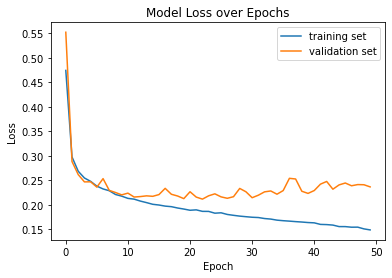

In [17]:

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training set','validation set'])
plt.show()

In [18]:
label = ['t']

def makeRoc(features_val, labels_val, labels, model, outputDir='', outputSuffix=''):
    from sklearn.metrics import roc_curve, auc
    labels_pred = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,8))
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = labels_pred[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='black', linestyle='--')
    #plt.semilogy()
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'DGCNN ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    #plt.savefig('%sROC_%s.pdf'%(outputDir, outputSuffix))
    return labels_pred

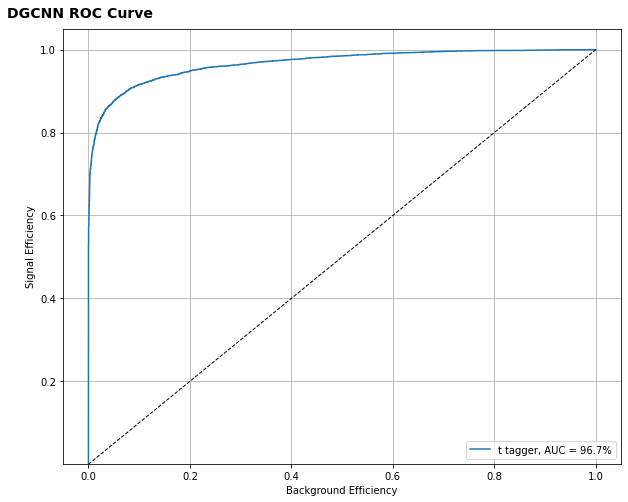

In [19]:
y_pred = makeRoc(X_test, y_test, label, model, outputSuffix='DGCNN')